In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,12]

In [132]:
df = pd.read_csv('./strains_with_id.csv')
df.head(20)

,name,description,parents,Aroused,Creative,Energetic,Euphoric,Focused,Giggly,Happy,...,Spasticity,Paranoid,Anxious,Dry Eyes,Dry Mouth,Headache,Stress,avg rating,num ratings,id
0,Sweet Nina,Sweet Nina by Colorado Seed Inc. is a hybrid c...,"indica:hindu-kush,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,100.00,100.00,5.56,0.00,0.00,0.0,3.857143,6.0,hybrid:sweet-nina
1,Hawaiian Purple Kush,Hawaiian Purple Kush is an 80/20 indica-domina...,"sativa:hawaiian,indica:purple-kush,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,92.86,2.38,97.62,100.00,0.00,0.0,4.486486,32.0,indica:hawaiian-purple-kush
2,Lime Purple Mist,Lime Purple Mist is an indica-dominant strain ...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,100.00,0.00,0.0,4.333333,4.0,indica:lime-purple-mist
3,F'n louZER,F’n louZER is another potent genetic cross fro...,"indica:bloos-kloos,indica:white-rhino,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,100.00,0.00,100.00,100.00,100.00,0.0,NaN,NaN,indica:fn-louzer
4,Goldwing,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,50.00,0.00,50.00,100.00,50.00,0.0,4.666667,2.0,sativa:goldwing
5,Arabian Gold,Arabian Gold is a heavy sativa strain of myste...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.50,0.00,62.50,100.00,0.00,0.0,4.100000,7.0,sativa:arabian-gold
6,Madagascar,"Madagascar is an indica with a clean, floral s...",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,100.00,80.00,0.00,0.0,4.100000,7.0,indica:madagascar
7,Murkle,Murkle by OBSoul is the accidental genetic pai...,"indica:m-39,indica:purple-urkle,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,80.00,0.00,80.00,100.00,0.00,0.0,3.500000,2.0,indica:murkle
8,Berkeley,Berkeley is rumored to be the super-potent bot...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,66.67,100.00,83.33,66.67,50.00,0.0,4.315789,19.0,sativa:berkeley
9,Alf,The indica-dominant hybrid Alf was created by ...,"hybrid:animal-cookies,hybrid:cherry-pie,hybrid...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,100.00,0.00,0.0,5.000000,1.0,hybrid:alf


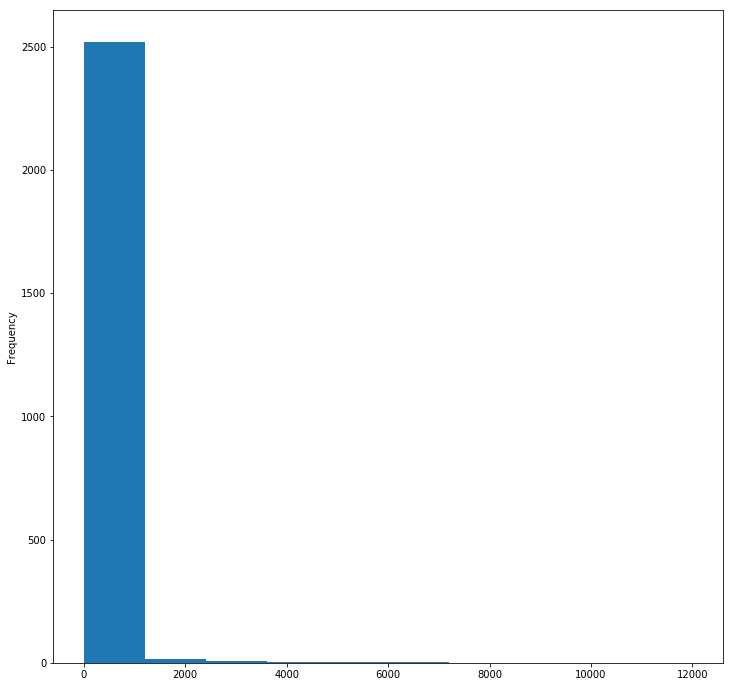

In [133]:
df['num ratings'].plot.hist(bins=10)

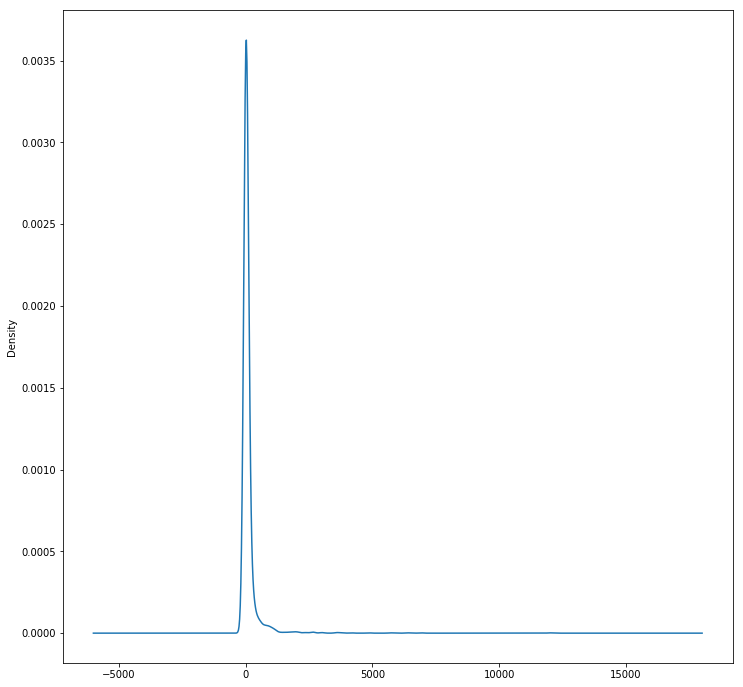

In [134]:
df['num ratings'].plot.density()

In [135]:
df.shape

(2669, 85)

In [136]:
parents=df['parents'].str.split(',',expand=True).head()
parents

,0,1,2,3,4,5,6,7
0,indica:hindu-kush,,None,None,None,None,None,None
1,sativa:hawaiian,indica:purple-kush,,None,None,None,None,None
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,indica:bloos-kloos,indica:white-rhino,,None,None,None,None,None
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
parents[7].unique()

array([None, nan], dtype=object)

In [138]:
# TODO Really need to get the flavor thing fixed.
df0=df
df0.shape

(2669, 85)

In [139]:
df1=df0#.dropna(subset=['num ratings'])
df1.shape

(2669, 85)

In [140]:
import json
# Handle name changes that redirect but the backend was never updated
substituition_dict = {"hybrid:girl-scout-cookie":"hybrid:gsc","hybrid:platinum-girl-scout-cookies":"hybrid:platinum-gsc","hybrid:platinum-girl-scout-cookie":"hybrid:platinum-gsc"}

def category(strain_id):
    categories = {"sativa":1,"hybrid":2,"indica":3}
    return categories[strain_id.split(':')[0]]

parent_ids=set() # All ids that show up in parents, thus we need them even if they don't have children
    
def precompute_ids(row):
        found_ids.add(row["id"])
        if (row["parents"] and type(row["parents"])==str):
            for p in row["parents"].split(','):
                if not len(p):
                    continue
                elif p in substituition_dict:
                    parent_ids.add(substituition_dict[p])
                else:
                    parent_ids.add(p)


found_ids=set()
missing_ids=set()
nodes = []
links = []
info = {}
def calculate(row):
    strain_id = row["id"]
    group = category(strain_id)
    parent_list = []
    if (row["parents"] and type(row["parents"]) == str):
        for p in row["parents"].split(','):
            if not len(p):
                continue
            elif p in substituition_dict:
                parent = substituition_dict[p]
            elif p not in found_ids:
                missing_ids.add(p)
                print("Strain %s is missing parent %s"%(strain_id,p))
                continue
            else:
                parent = p
            parent_list.append(parent) 
            # TODO what should the link value be? Do we even want one?
            links.append({ "source": parent, "target": strain_id})
        row["parents"] = parent_list
    if len(parent_list) or strain_id in parent_ids:
        nodes.append({"id": strain_id, "name": row["name"], "group": group})
        info[strain_id]=row.to_json()
    else:
        print("Strain %s has no parents or children, discarding record" % strain_id,)
def reformat():

    df1.apply(precompute_ids,axis=1)        
    df1.apply(calculate,axis=1)
    if len(missing_ids):
        print("Warning, the following ids are missing and were ignored:")
        print(missing_ids)
    print("Total number of nodes output: %d" %len(nodes),) 
    
#     # TODO make this suck a bit less
reformat()
df_nodes=pd.DataFrame(data=nodes)
df_nodes.set_index('id',inplace=True,verify_integrity=True)
df_edges=pd.DataFrame(data=links)


Strain indica:lime-purple-mist has no parents or children, discarding record
Strain sativa:goldwing has no parents or children, discarding record
Strain sativa:arabian-gold has no parents or children, discarding record
Strain indica:madagascar has no parents or children, discarding record
Strain sativa:berkeley has no parents or children, discarding record
Strain hybrid:rocky-mountain-high has no parents or children, discarding record
Strain hybrid:broke-diesel has no parents or children, discarding record
Strain hybrid:the-boss has no parents or children, discarding record
Strain hybrid:smelliot has no parents or children, discarding record
Strain hybrid:el-na has no parents or children, discarding record
Strain indica:og-eddy-lepp has no parents or children, discarding record
Strain hybrid:x-file has no parents or children, discarding record
Strain hybrid:little-devil has no parents or children, discarding record
Strain hybrid:redding-og has no parents or children, discarding record


Strain sativa:moby-dick has no parents or children, discarding record
Strain indica:sunset has no parents or children, discarding record
Strain indica:chef-kush has no parents or children, discarding record
Strain hybrid:clementine-kush has no parents or children, discarding record
Strain hybrid:gorilla-cookies is missing parent hybrid:gorilla-glue-4
Strain hybrid:orange-velvet is missing parent Dry Mouth:100.0
Strain hybrid:orange-velvet is missing parent Dry Eyes:66.67
Strain hybrid:orange-velvet is missing parent Anxious:55.56
Strain hybrid:orange-velvet is missing parent Dizzy:33.33
Strain hybrid:orange-velvet is missing parent Paranoid:22.22
Strain indica:xxx-og has no parents or children, discarding record
Strain hybrid:the-white is missing parent Pine
Strain hybrid:the-white is missing parent Spicy/Herbal
Strain hybrid:the-white is missing parent Pungent
Strain indica:enemy-of-the-state has no parents or children, discarding record
Strain hybrid:22 has no parents or children, di

In [141]:
df_edges.head()

,source,target
0,indica:hindu-kush,hybrid:sweet-nina
1,sativa:hawaiian,indica:hawaiian-purple-kush
2,indica:purple-kush,indica:hawaiian-purple-kush
3,indica:bloos-kloos,indica:fn-louzer
4,indica:white-rhino,indica:fn-louzer


In [142]:
# Error: cycles that are clearly mistakes:
df_edges.drop(df_edges[((df_edges['target']=='indica:purple-afghani') & (df_edges['source']=='indica:purple-kush'))].index,inplace=True)
df_edges.drop(df_edges[((df_edges['target']=='sativa:timewreck') & (df_edges['source']=='sativa:timewreck'))].index,inplace=True)

In [144]:
df_nodes.shape

(2186, 2)

In [146]:
df_nodes.head()

,group,name
id,,
hybrid:sweet-nina,2,Sweet Nina
indica:hawaiian-purple-kush,3,Hawaiian Purple Kush
indica:fn-louzer,3,F'n louZER
indica:murkle,3,Murkle
hybrid:alf,2,Alf


In [147]:
df_edges.head()

,source,target
0,indica:hindu-kush,hybrid:sweet-nina
1,sativa:hawaiian,indica:hawaiian-purple-kush
2,indica:purple-kush,indica:hawaiian-purple-kush
3,indica:bloos-kloos,indica:fn-louzer
4,indica:white-rhino,indica:fn-louzer


In [148]:
df_edges[df_edges.target.isin(df_nodes.index)].head()

,source,target
0,indica:hindu-kush,hybrid:sweet-nina
1,sativa:hawaiian,indica:hawaiian-purple-kush
2,indica:purple-kush,indica:hawaiian-purple-kush
3,indica:bloos-kloos,indica:fn-louzer
4,indica:white-rhino,indica:fn-louzer


In [149]:
df_edges2=df_edges[df_edges.target.isin(df_nodes.index)]
df_edges2=df_edges2[df_edges2.source.isin(df_nodes.index)]
df_edges2.head()

,source,target
0,indica:hindu-kush,hybrid:sweet-nina
1,sativa:hawaiian,indica:hawaiian-purple-kush
2,indica:purple-kush,indica:hawaiian-purple-kush
3,indica:bloos-kloos,indica:fn-louzer
4,indica:white-rhino,indica:fn-louzer


In [150]:
df_edges[df_edges.source=='hybrid:sunlight-skunk']

,source,target


In [151]:
G=nx.DiGraph(df_edges2,edge_attr=True)
G

In [152]:
are_good=nx.is_directed_acyclic_graph(G)
print("We are good if this says true: ",are_good)
if not are_good:
    print(nx.find_cycle(G))

We are good if this says true:  True


In [191]:
source_nodes=[]
for (strain_id,value) in G.in_degree():
    if value == 0:
        source_nodes.append(strain_id)
print(source_nodes)

['indica:hindu-kush', 'sativa:hawaiian', 'hybrid:skunk-1', 'hybrid:og-kush', 'indica:frankenstein', 'hybrid:the-white', 'indica:pre-98-bubba-kush', 'indica:double-purple-doja', 'indica:silverback-gorilla', 'sativa:south-indian', 'hybrid:nebula', 'sativa:charlottes-web', 'indica:afghani', 'indica:sensi-star', 'indica:g-13', 'hybrid:bubble-gum', 'sativa:thai', 'sativa:central-american', 'hybrid:burmese-kush', 'sativa:super-lemon-haze', 'hybrid:ocas-cloud-9', 'indica:triangle-kush', 'sativa:strawberry-cough', 'hybrid:24k-gold', 'indica:north-indian', 'sativa:mexican', 'indica:eastern-european', 'hybrid:silver-surfer', 'hybrid:dutch-treat', 'sativa:matanuska-thunder-fuck', 'sativa:african', 'hybrid:the-one', 'sativa:lemon-thai', 'hybrid:ginger-ale', 'sativa:jamaican', 'hybrid:tahoe-alien', 'hybrid:blockhead', 'hybrid:california-orange', 'hybrid:saturn-og', 'indica:kosher-kush', 'indica:purple-elephant', 'sativa:nepalese', 'hybrid:green-ribbon', 'hybrid:pink-panther', 'sativa:south-american

In [ ]:
df_nodes.insert(2,'depth',1000)

In [161]:
for src in source_nodes:
    df_nodes.at[src,'depth']=0
df_nodes.sort_values('depth').head(10)

,group,name,depth
id,,,
hybrid:skunk-1,2,Skunk No. 1,0
indica:frosty,3,Frosty,0
indica:raspberry-kush,3,Raspberry Kush,0
hybrid:happy-rancher,2,Happy Rancher,0
indica:north-indian,3,North Indian,0
hybrid:tahoe-alien,2,Tahoe Alien,0
indica:chemo,3,Chemo,0
sativa:early-pearl,1,Early Pearl,0
indica:fucking-incredible,3,Fucking Incredible,0


In [175]:
len(source_nodes)

120

In [168]:
while not nx.is_empty(G):
    longest_path=nx.dag_longest_path(G)
    deepest_node=longest_path[-1]
    df_nodes.at[deepest_node,'depth']=len(longest_path)-1
    G.remove_node(deepest_node)

In [177]:
df_nodes['depth'].value_counts()

3    471
4    423
2    393
5    301
1    291
6    136
0    120
7     47
8      4
Name: depth, dtype: int64

In [187]:
def calculate_dist(d):
    parent_depth= df_nodes.at[d['source'],'depth']
    child_depth=df_nodes.at[d['target'],'depth']
    return child_depth-parent_depth
df_edges2['distance'] = df_edges2.apply(calculate_dist,axis=1)
df_edges2.head()

,source,target,distance
0,indica:hindu-kush,hybrid:sweet-nina,1
1,sativa:hawaiian,indica:hawaiian-purple-kush,3
2,indica:purple-kush,indica:hawaiian-purple-kush,1
3,indica:bloos-kloos,indica:fn-louzer,1
4,indica:white-rhino,indica:fn-louzer,3


In [188]:
# This should be empty:
df_edges2[df_edges2['distance']==0]

,source,target,distance


In [195]:
# reset the graph
G=nx.DiGraph(df_edges2,edge_attr=True)
leaf_nodes=[]
for (strain_id,value) in G.out_degree():
    if value == 0:
        leaf_nodes.append(strain_id)
print(leaf_nodes)
print(len(leaf_nodes))

['hybrid:sweet-nina', 'indica:fn-louzer', 'indica:murkle', 'hybrid:alf', 'hybrid:northern-cross', 'hybrid:damnesia', 'hybrid:sunlight-skunk', 'hybrid:white-ryder', 'hybrid:loyality', 'indica:sweet-lafayette', 'sativa:alpha-cow', 'hybrid:armagnac', 'indica:bubba-doja', 'hybrid:peyton-manning', 'hybrid:diamond-socks', 'hybrid:bootlegger', 'sativa:doox', 'indica:kelly-hill-gold', 'indica:pestilence', 'indica:ifc-og', 'sativa:haze-mist', 'indica:space-monster', 'hybrid:spyder-mon', 'hybrid:sorcerers-apprentice', 'hybrid:white-walrus', 'hybrid:brain-candy', 'hybrid:goat', 'hybrid:chairman-chem-sou', 'hybrid:cello-sweet-og', 'sativa:kaboom', 'indica:tonics-web', 'hybrid:batgirl', 'hybrid:prismatic-jack', 'hybrid:cheesewreck', 'hybrid:lazy-train', 'hybrid:afghanica', 'hybrid:boggle-gum', 'indica:afghanimal', 'hybrid:the-big-dirty', 'hybrid:gupta-haze', 'hybrid:pan-jam', 'indica:sumo-og-kush', 'indica:berry-noir', 'hybrid:flowers-for-algernon', 'indica:la-ultra', 'indica:denver-maple', 'indica

In [207]:
df.set_index('id').iat[leaf_nodes]

ValueError: Invalid call for scalar access (getting)!

In [ ]:
df_nodes[df_nodes['id']=='hybrid:chernobyl']

In [ ]:
df_nodes[df_nodes['id']=='hybrid:northern-cross']

In [ ]:
with open('strains_formatted.json','w') as outfile:
         json.dump({"nodes":df_nodes.to_dict(orient='records'), "links":df_edges2.to_dict(orient='records'),"info":info},outfile)